# Digit Recognizer

## Competition Description

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

## Practice Skills
* Computer vision fundamentals including simple neural networks
* Classification methods such as SVM and K-nearest neighbors

## Acknowledgements

More details about the dataset, including algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html. The dataset is made available under a Creative Commons Attribution-Share Alike 3.0 license.

## Data Description

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:

  000 001 002 003 ... 026 027<br>
  028 029 030 031 ... 054 055<br>
  056 057 058 059 ... 082 083<br>
   |   |   |   |  ...  |   |<br>
  728 729 730 731 ... 754 755<br>
  756 757 758 759 ... 782 783<br>

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

ImageId,Label<br>
1,3<br>
2,7<br>
3,8<br>
(27997 more lines)<br>

The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images.

## So let's begin here...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
%matplotlib inline

Using TensorFlow backend.


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


## Load Data

In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Number of Labels

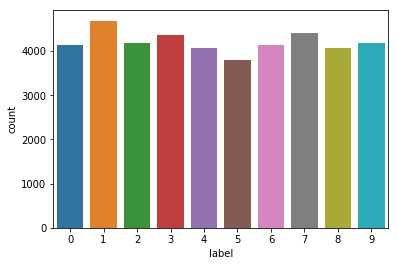

In [3]:
sns.countplot(train['label'])

Setting datatypes for pixels and labels

In [4]:
x_train = (train.iloc[:,1:].values).astype('float32') # all pixels
y_train = train.iloc[:,0].values.astype('int32') # all labels
x_test = test.values.astype('float32') # all pixels

## Let's have a look at our data

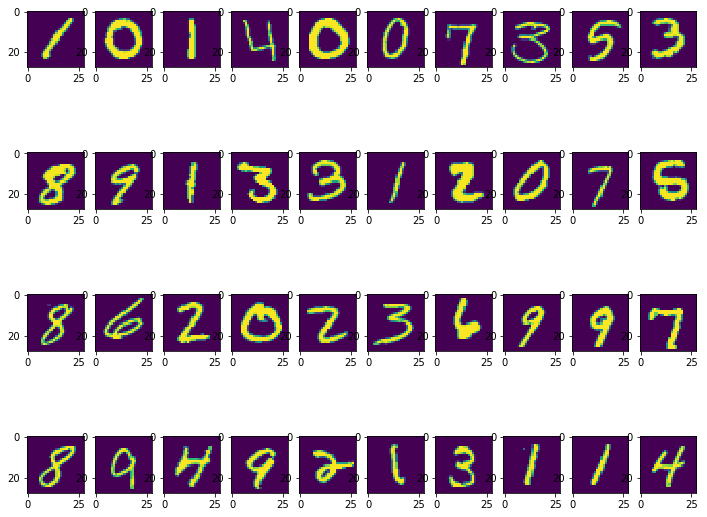

In [5]:
%matplotlib inline
# preview the images first
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)),interpolation='nearest')
plt.show()

In [6]:
x_train = x_train/255.0
x_test = x_test/255.0

In [7]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

42000 train samples
28000 test samples


#### Reshape

In [8]:
X_train = x_train.reshape(x_train.shape[0], 28, 28,1)
X_test = x_test.reshape(x_test.shape[0], 28, 28,1)

Splitting our train data into train and validation data

In [9]:
y_train = keras.utils.to_categorical(y_train, 10)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

In [10]:
batch_size = 64
epochs = 20
input_shape = (28, 28, 1)

## Define Model

In [11]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation='softmax'))

## Compile Model

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

## Fit Model

In [14]:
datagen.fit(X_train)
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size), 
                    epochs = epochs, validation_data = (X_val,Y_val),
                    verbose = 1, 
                    steps_per_epoch = X_train.shape[0] // batch_size
                   )

Epoch 1/20
590/590 [==============================] - 18s 30ms/step - loss: 0.3352 - accuracy: 0.8938 - val_loss: 0.1177 - val_accuracy: 0.9657
Epoch 2/20
590/590 [==============================] - 15s 25ms/step - loss: 0.1082 - accuracy: 0.9668 - val_loss: 0.0376 - val_accuracy: 0.9895
Epoch 3/20
590/590 [==============================] - 15s 25ms/step - loss: 0.0816 - accuracy: 0.9746 - val_loss: 0.0309 - val_accuracy: 0.9893
Epoch 4/20
590/590 [==============================] - 15s 25ms/step - loss: 0.0683 - accuracy: 0.9795 - val_loss: 0.0401 - val_accuracy: 0.9864
Epoch 5/20
590/590 [==============================] - 14s 24ms/step - loss: 0.0636 - accuracy: 0.9800 - val_loss: 0.0313 - val_accuracy: 0.9912
Epoch 6/20
590/590 [==============================] - 14s 24ms/step - loss: 0.0566 - accuracy: 0.9834 - val_loss: 0.0385 - val_accuracy: 0.9886
Epoch 7/20
590/590 [==============================] - 15s 26ms/step - loss: 0.0513 - accuracy: 0.9848 - val_loss: 0.0210 - val_accuracy:

## Predictions

In [15]:
predictions = model.predict(X_test)
results = np.argmax(predictions, axis = 1)

## Submission

In [16]:
submissions = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
submissions['Label'] = results
submissions.to_csv('submission.csv', index = False)